**Création d'un algorithme de détection automatique de faux billets**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

# Importer et compléter le jeu de données :

In [2]:
billets = pd.read_csv('billets.csv', sep=';')

In [3]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [4]:
def findNaNCols(df):
    for col in df:
        print(f"Column: {col}")
        num_NaNs = df[col].isnull().sum()
        print(f"Number of NaNs: {num_NaNs}")

findNaNCols(billets)

Column: is_genuine
Number of NaNs: 0
Column: diagonal
Number of NaNs: 0
Column: height_left
Number of NaNs: 0
Column: height_right
Number of NaNs: 0
Column: margin_low
Number of NaNs: 37
Column: margin_up
Number of NaNs: 0
Column: length
Number of NaNs: 0


In [5]:
billets_manquants = billets[billets['margin_low'].isna()]
billets_manquants

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


Pour 37 billets, le champ "margin-low" n'a pas été renseigné. Afin de compléter au mieux les données manquantes, nous allons procéder à une régression linéaires pour déduire les valeurs "margin_low".

In [6]:
billets.is_genuine.value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

## Visualiser le jeu de données test

In [7]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


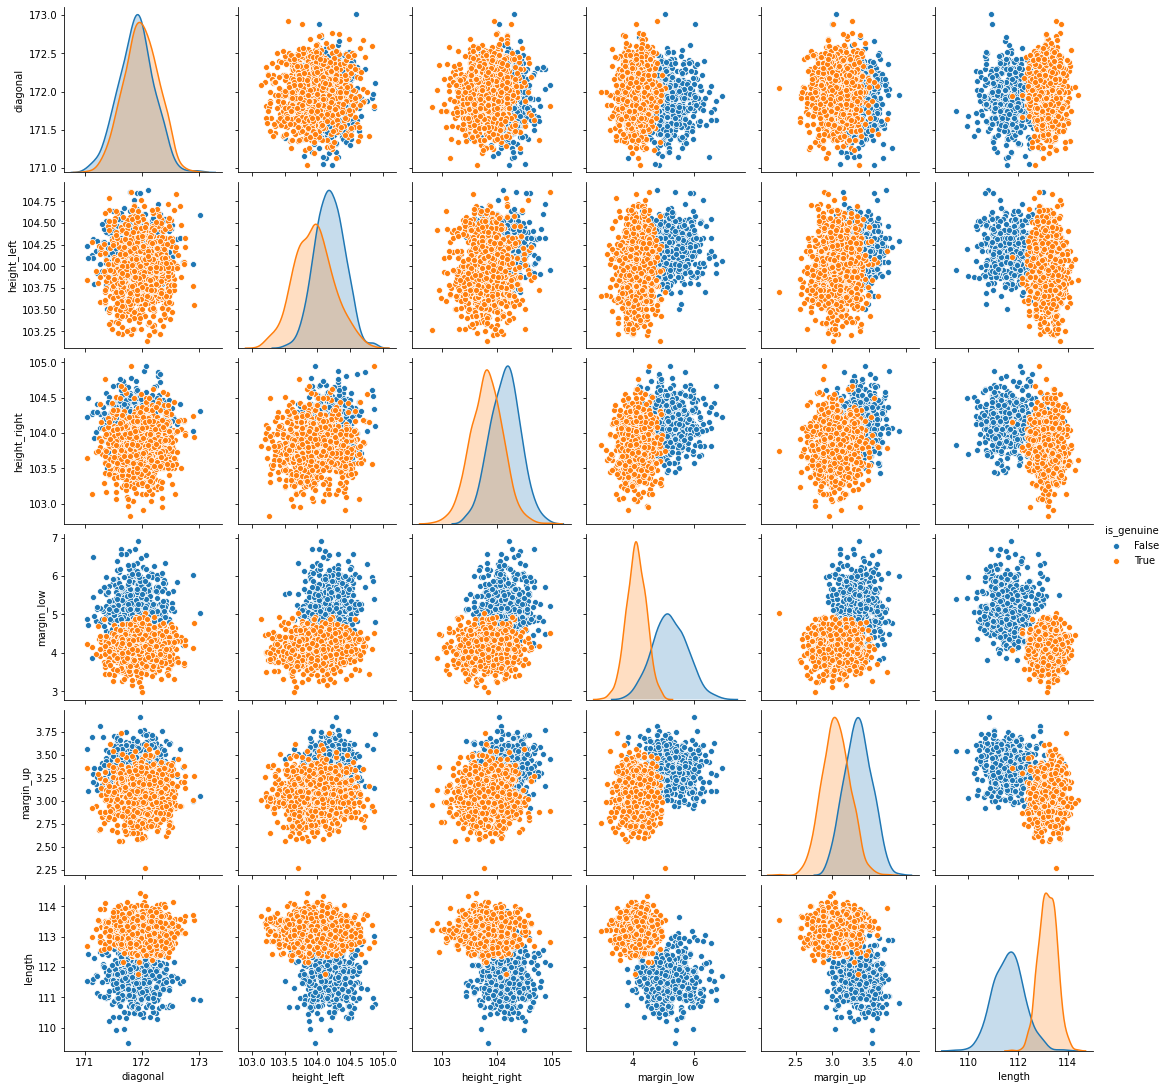

In [8]:
import seaborn as sns
#sns.set_theme(style="ticks")

sns.pairplot(billets, hue="is_genuine")

En observant les distributions et les représentations des variables selon que les billets soient vrais ou faux, on s'apperçoit que les deux variables qui séparent clairement les deux groupes sont 'length' et 'margin_low'. Comme les données manquantes du data set sont des informations sur la marge basse, nous allons réaliser, dans un premier temps, un modèle avec une regression linéaire simple avec la longueur.

## Tenter un modèle de regression linéaire simple

### Régression linéaire simple sur le jeu test complet :

In [9]:
billets_complets = billets.dropna()

#### Estimation du modèle :

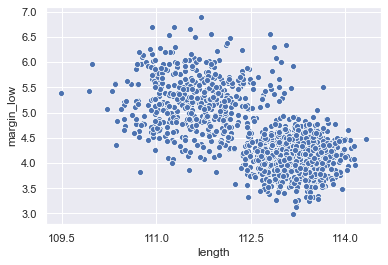

In [10]:
sns.set()

ax = sns.scatterplot(x="length", y="margin_low", data=billets_complets)
ax.set(xlabel='length', ylabel='margin_low')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

In [11]:
reg_simp = smf.ols('margin_low ~length', data=billets_complets).fit()

In [12]:
print(reg_simp.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1169.
Date:                Mon, 07 Feb 2022   Prob (F-statistic):          8.98e-189
Time:                        09:28:32   Log-Likelihood:                -1045.8
No. Observations:                1463   AIC:                             2096.
Df Residuals:                    1461   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.5960      1.670     36.881      0.0

**Il apparaît que ce modèle avec ces deux seules variables est insuffisant pour rendre compte des billets : le R2 est de 0,44.**

#### Représentation du modèle :

<ipython-input-13-323832372c39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billets_complets['margin_low_ajuste'] = reg_simp.predict()


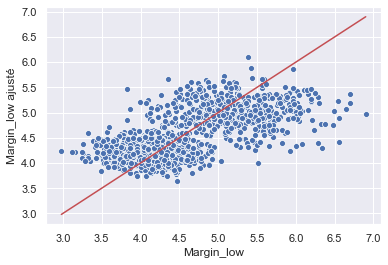

In [13]:
billets_complets['margin_low_ajuste'] = reg_simp.predict()

X_plot = [billets_complets['margin_low'].min(), billets_complets['margin_low'].max()]

ax = sns.scatterplot(x="margin_low", y="margin_low_ajuste", data=billets_complets)
ax.set(xlabel='Margin_low', ylabel='Margin_low ajusté')
plt.plot(X_plot, X_plot, color='r')
plt.show()

**Le modèle serait parfait si les valeurs réelles et les valeurs ajustées étaient égales, c'est-à-dire les points seraient alignés sur la droite d'équation  𝑦=𝑥 , soit la première bissectrice. Or le modèle ne capte que très peu de points.**

#### Représentation des résidus :

In [14]:
billets_complets['residu_s'] = reg_simp.resid

<ipython-input-14-6b10beb995c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billets_complets['residu_s'] = reg_simp.resid


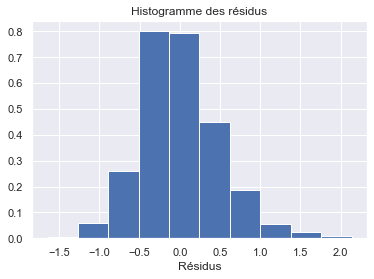

In [15]:
plt.hist(billets_complets['residu_s'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

L'histogramme est légèrement asymétrique : les résidus ne suivent pas une loi normale, leur distribution n'est pas totalement aléatoire. 

### Régression linéaire simple sur les billets vrais / faux :

Peut-être qu'en observant les vrais et les faux billets séparément, le modèle de régression linéaire s'appliquera mieux.

In [16]:
billets_vrais = billets[billets['is_genuine']==True]
billets_faux = billets[billets['is_genuine']==False]

billets_vrais

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
995,True,171.66,103.92,103.47,4.26,2.83,113.20
996,True,172.16,103.72,103.61,4.30,2.72,113.51
997,True,171.78,103.38,104.22,4.23,3.07,113.77
998,True,171.44,103.96,103.92,3.68,2.89,113.21


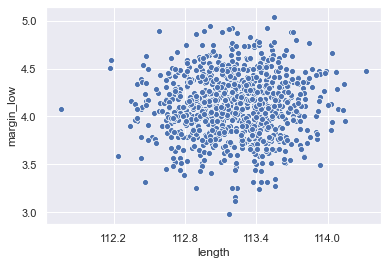

In [17]:
sns.set()

ax = sns.scatterplot(x="length", y="margin_low", data=billets_vrais)
ax.set(xlabel='length', ylabel='margin_low')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

In [18]:
reg_simp_vrai = smf.ols('margin_low ~ length', data=billets_vrais).fit()

In [19]:
print(reg_simp_vrai.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.455
Date:                Mon, 07 Feb 2022   Prob (F-statistic):              0.228
Time:                        09:28:33   Log-Likelihood:                -267.51
No. Observations:                 971   AIC:                             539.0
Df Residuals:                     969   BIC:                             548.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1885      3.256      0.058      0.9

In [20]:
reg_simp_faux = smf.ols('margin_low ~ length', data=billets_faux).fit()

In [21]:
print(reg_simp_faux.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4591
Date:                Mon, 07 Feb 2022   Prob (F-statistic):              0.498
Time:                        09:28:33   Log-Likelihood:                -406.40
No. Observations:                 492   AIC:                             816.8
Df Residuals:                     490   BIC:                             825.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2881      4.534      1.828      0.0

**Quand on s'intéresse aux mesures des billets en séparant les vrais des faux, le R2 est proche de 0.**

**Par contre, la p-value pour length est très au-delà du seuil de 5%.**

## Regression linéaire multiple

### Estimation du modèle

In [22]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Building Model
from sklearn import linear_model
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (7, 7)
plt.style.use('ggplot')

# Load dataset

In [23]:
reg_multi = smf.ols('margin_low~margin_up+length+height_right+height_left+diagonal', data=billets_complets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Mon, 07 Feb 2022   Prob (F-statistic):          2.60e-202
Time:                        09:28:33   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

**On constate ici que tous les paramètres (P>|t|) sont proches de 0, car leur p-valeur est inférieure à 5 %, le niveau de test que nous souhaitons. Toutes les variables sont donc significative dans le modèle. Nous ne pouvons donc pas retirer de variables non significatives pour améliorer le modèle.**

**Le  𝑅2  vaut environ 0.477, et le  𝑅2  ajusté est d'environ 0.476, ce qui est un peu mieux que pour la regression linéaire simple, mais ne rend pas suffisamment compte des billets pour établir un modèle.**

### Analyse de l'atypicité et de l'influence des observations :

Nous allons ici réaliser les tests à un niveau  𝛼=5 % :

In [24]:
alpha = 0.05

Récupérons  𝑛 , le nombre d'individus de l'échantillon, et  𝑝 , le nombre de variables.

In [25]:
n = billets_complets.shape[0]
p = 6

Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé analyses.

In [26]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

#### Calculez les leviers

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de  2∗(𝑝/𝑛) .

In [27]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

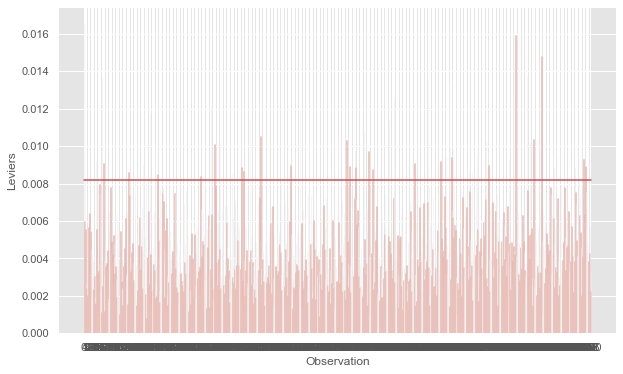

In [28]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1463, step=4))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1463], [seuil_levier, seuil_levier], color='r')
plt.show()

Pour sélectionner les points pour lesquels le levier est supérieur au seuil, on exécute la ligne suivante :

In [29]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
0,1,0.016606
2,3,0.008298
34,35,0.009156
52,53,0.013635
56,57,0.009087
...,...,...
1416,1417,0.008521
1417,1418,0.008870
1428,1429,0.008390
1441,1442,0.009325


#### Calculez les résidus studentisés

Pour calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [30]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

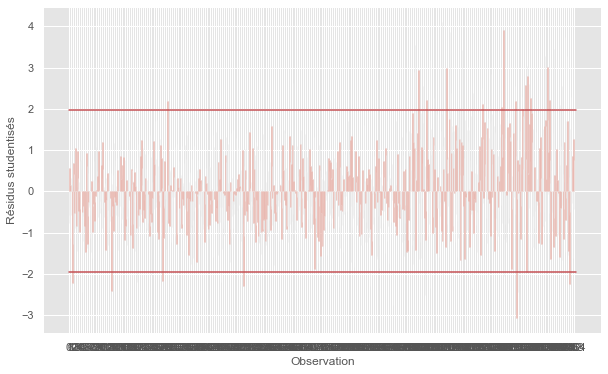

In [31]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1468, step=6))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1468], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1468], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [32]:
valeurs_atypiques = analyses.loc[analyses['rstudent'] > seuil_rstudent, :]

In [33]:
valeurs_atypiques.count()

obs         53
levier      53
rstudent    53
dtype: int64

#### Déterminez la distance de Cook

In [34]:
influence = reg_multi.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p.

In [35]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

On peut détecter les observations influentes comme ceci :

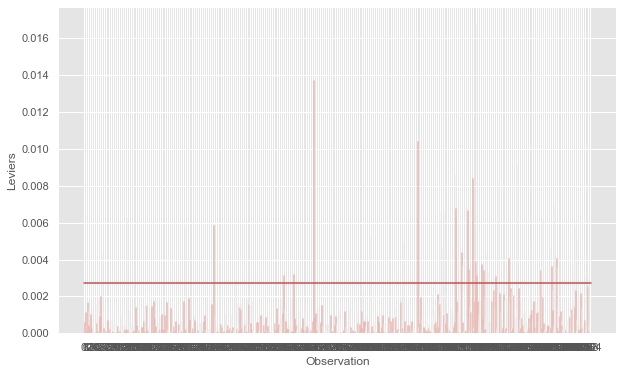

In [36]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1468, step=6))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1468], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [37]:
valeurs_influentes = analyses.loc[analyses['dcooks'] > seuil_dcook, :]

In [38]:
valeurs_influentes

,obs,levier,rstudent,dcooks
52,53,0.013635,-1.372229,0.004338
80,81,0.003806,0.022997,0.003151
125,126,0.001589,0.172284,0.006308
243,244,0.002601,0.239331,0.004207
292,293,0.002852,0.522537,0.005768
...,...,...,...,...
1420,1421,0.006084,-1.590104,0.005875
1426,1427,0.005088,-1.669093,0.005099
1441,1442,0.009325,3.280337,0.009596
1450,1451,0.006730,-0.493361,0.003099


**On retire les points atypiques et influents.**

In [39]:
points_a_retirer = set(valeurs_atypiques.obs).intersection(valeurs_influentes.obs)
points_a_retirer

{1196, 1292, 1322, 1442}

In [40]:
points_a_retirer0 = pd.concat([valeurs_influentes, valeurs_atypiques], axis=1, join="inner")
points_a_retirer0

,obs,levier,rstudent,dcooks,obs,levier,rstudent
1195,1196,0.001681,2.504636,0.002971,1196,0.001681,2.504636
1291,1292,0.005626,2.564383,0.003240,1292,0.005626,2.564383
1321,1322,0.001112,2.582140,0.003448,1322,0.001112,2.582140
1441,1442,0.009325,3.280337,0.009596,1442,0.009325,3.280337


In [41]:
billets_complets.loc[[1196,1292,1322,1442]]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_ajuste,residu_s
1196,False,171.94,104.04,104.27,4.75,3.16,111.61,5.025647,-0.275647
1292,False,171.86,104.04,104.43,4.63,3.64,111.63,5.015510,-0.385510
1322,False,172.07,104.50,104.23,6.19,3.07,111.21,5.228390,0.961610
1442,False,171.40,104.21,104.44,5.59,3.30,111.09,5.289213,0.300787


#### Modèle sans les points atypiques et influents :

In [42]:
billets_semblables = billets_complets.drop([1196,1292,1322,1442])

In [43]:
reg_multi = smf.ols('margin_low~margin_up+length+height_right+height_left+diagonal', data=billets_semblables).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     264.0
Date:                Mon, 07 Feb 2022   Prob (F-statistic):          5.87e-201
Time:                        09:29:12   Log-Likelihood:                -997.62
No. Observations:                1459   AIC:                             2007.
Df Residuals:                    1453   BIC:                             2039.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       23.2110      9.654      2.404   

**On remarque qu'en enlevant les valeurs influentes et atypiques, le R2 n'est guère meilleur.** 

**Comme le score de Durbin-Watson est compris entre 1,5 et 2,5 (1,899), on peut supposer qu'il n'y a pas d'autocorrélation dans les résidus.**

In [44]:
billets_semblables

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_ajuste,residu_s
0,True,171.81,104.86,104.95,4.52,2.89,112.83,4.407281,0.112719
1,True,171.46,103.36,103.66,3.77,2.99,113.09,4.275498,-0.505498
2,True,172.69,104.48,103.50,4.40,2.94,113.16,4.240018,0.159982
3,True,171.36,103.91,103.94,3.62,3.01,113.51,4.062618,-0.442618
4,True,171.73,104.28,103.46,4.04,3.48,112.54,4.554270,-0.514270
...,...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,5.192910,-0.772910
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,5.350036,-0.080036
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,4.853316,0.656684
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,4.701259,0.468741


**Représentation des résidus :**

p-value from the test Anderson-Darling test below 0.05 generally means non-normal: 5.742235657324676e-13


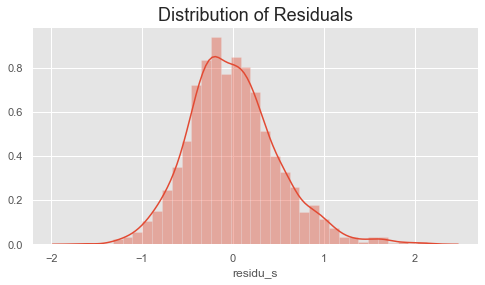

Les résidus ne sont pas normalement distribués


In [45]:
from statsmodels.stats.diagnostic import normal_ad

# Performing the test on the residuals
p_value = normal_ad(billets_semblables['residu_s'])[1]
print('p-value from the test Anderson-Darling test below 0.05 generally means non-normal:', p_value)

# Plotting the residuals distribution
plt.subplots(figsize=(8, 4))
plt.title('Distribution of Residuals', fontsize=18)
sns.distplot(billets_semblables['residu_s'])
plt.show()

# Reporting the normality of the residuals
if p_value < 0.05:
    print('Les résidus ne sont pas normalement distribués')
else:
    print('Les résidus sont normalement distribués')


### Vérifier la colinéarité des variables :

In [46]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.4054546238478796,
 1.573404824858451,
 1.2265659657422958,
 1.1375874110884638,
 1.0132570688907894]

Ici, tous les coefficients du facteur d'influence de la variance sont inférieurs à 10, il n'y a donc pas de problème de colinéarité. On peut faire la régression.

### Testez l’homoscédasticité des résidus :

In [47]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 8.991613296698526e-16


La p-valeur ici est très inférieure à  5 %, on ne rejette pas l'hypothèse d’homoscédasticité, selon laquelle les variances sont constantes.

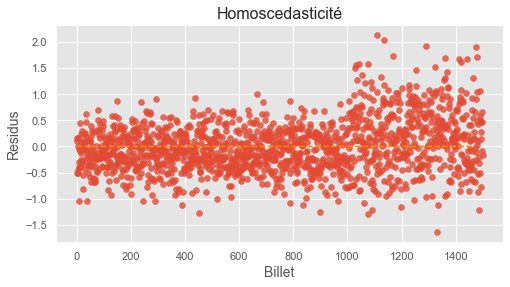

In [48]:
# Plotting the residuals
plt.subplots(figsize=(8, 4))
plt.scatter(x=billets_semblables.index, y=billets_semblables.residu_s, alpha=0.8)
plt.plot(np.repeat(0, len(billets_semblables.index)+2), color='darkorange', linestyle='--')

plt.ylabel('Residus', fontsize=14)
plt.xlabel('Billet', fontsize=14)
plt.title('Homoscedasticité', fontsize=16)
plt.show()  

**Un nuage avec une forme conique laisse présager un effet hétéroscédastique.**

### Vérification empirique de l'exactitude de l'équation et imputation :

In [49]:
billets_manquants.margin_low = 22.9948 + 0.2562*billets_manquants.margin_up -0.4091*billets_manquants.length +0.2571*billets_manquants.height_right +0.1841*billets_manquants.height_left -0.1111*billets_manquants.diagonal

In [50]:
billets_manquants.margin_low

72      4.305671
99      4.380782
151     4.397562
197     4.306178
241     4.637735
251     3.790496
284     4.166874
334     4.114575
410     4.122156
413     4.147673
445     4.164545
481     3.755691
505     4.045882
611     4.285203
654     4.147747
675     4.081201
710     4.426969
739     4.457780
742     4.328759
780     4.067528
798     3.601448
844     4.358924
845     4.080732
871     4.236782
895     3.880891
919     3.733479
945     4.224553
946     4.697646
981     4.124904
1076    5.037389
1121    4.789272
1176    5.054715
1303    5.034673
1315    4.766075
1347    5.714107
1435    5.172933
1438    5.127146
Name: margin_low, dtype: float64

**Les valeurs de 'margin_low' doivent être comprises entre 2,98 et 6,90. Les valeurs proposées par le modèles sont donc plausibles.**

### Remplacement des valeurs manquantes par les valeurs du modèle :

In [51]:
billets_semblables = billets_semblables.reset_index()

In [52]:
billets_semblables

,index,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_ajuste,residu_s
0,0,True,171.81,104.86,104.95,4.52,2.89,112.83,4.407281,0.112719
1,1,True,171.46,103.36,103.66,3.77,2.99,113.09,4.275498,-0.505498
2,2,True,172.69,104.48,103.50,4.40,2.94,113.16,4.240018,0.159982
3,3,True,171.36,103.91,103.94,3.62,3.01,113.51,4.062618,-0.442618
4,4,True,171.73,104.28,103.46,4.04,3.48,112.54,4.554270,-0.514270
...,...,...,...,...,...,...,...,...,...,...
1454,1495,False,171.75,104.38,104.17,4.42,3.09,111.28,5.192910,-0.772910
1455,1496,False,172.19,104.63,104.44,5.27,3.37,110.97,5.350036,-0.080036
1456,1497,False,171.80,104.01,104.12,5.51,3.36,111.95,4.853316,0.656684
1457,1498,False,172.06,104.28,104.06,5.17,3.46,112.25,4.701259,0.468741


In [53]:
billets_manquants = billets_manquants.reset_index()

In [54]:
billets_manquants

,index,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,72,True,171.94,103.89,103.45,4.305671,3.25,112.79
1,99,True,171.93,104.07,104.18,4.380782,3.14,113.08
2,151,True,172.07,103.80,104.38,4.397562,3.02,112.93
3,197,True,171.45,103.66,103.80,4.306178,3.62,113.27
4,241,True,171.83,104.14,104.06,4.637735,3.02,112.36
5,251,True,171.80,103.26,102.82,3.790496,2.95,113.22
6,284,True,171.92,103.83,103.76,4.166874,3.23,113.29
7,334,True,171.85,103.70,103.96,4.114575,3.00,113.36
8,410,True,172.56,103.72,103.51,4.122156,3.12,112.95
9,413,True,172.30,103.66,103.50,4.147673,3.16,112.95


In [55]:
billets_corriges = billets_semblables.append(billets_manquants, sort=False)

In [56]:
billets_corriges

,index,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_ajuste,residu_s
0,0,True,171.81,104.86,104.95,4.520000,2.89,112.83,4.407281,0.112719
1,1,True,171.46,103.36,103.66,3.770000,2.99,113.09,4.275498,-0.505498
2,2,True,172.69,104.48,103.50,4.400000,2.94,113.16,4.240018,0.159982
3,3,True,171.36,103.91,103.94,3.620000,3.01,113.51,4.062618,-0.442618
4,4,True,171.73,104.28,103.46,4.040000,3.48,112.54,4.554270,-0.514270
...,...,...,...,...,...,...,...,...,...,...
32,1303,False,172.17,104.49,103.76,5.034673,2.93,111.21,NaN,NaN
33,1315,False,172.08,104.15,104.17,4.766075,3.40,112.29,NaN,NaN
34,1347,False,171.72,104.46,104.12,5.714107,3.61,110.31,NaN,NaN
35,1435,False,172.66,104.33,104.41,5.172933,3.56,111.47,NaN,NaN


In [57]:
billets_corriges.describe()

,index,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_ajuste,residu_s
count,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1459.000000,1459.000000
mean,747.993316,171.958817,104.029084,103.919178,4.481000,3.151096,112.681959,4.484175,-0.000412
std,432.729146,0.305237,0.299578,0.325292,0.658415,0.231737,0.871237,0.441832,0.494545
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.490000,3.652064,-1.646613
25%,373.750000,171.750000,103.820000,103.707500,4.020000,2.990000,112.047500,4.148784,-0.333376
50%,747.500000,171.960000,104.040000,103.920000,4.310000,3.140000,112.970000,4.336321,-0.040018
75%,1121.250000,172.170000,104.230000,104.150000,4.870000,3.310000,113.342500,4.812767,0.286970
max,1499.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.440000,6.100185,2.137513


In [58]:
billets_corriges = billets_corriges.drop(columns=['margin_low_ajuste','residu_s'])

In [59]:
billets_corriges.groupby(by='is_genuine').count()

,index,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,,
False,496,496,496,496,496,496,496
True,1000,1000,1000,1000,1000,1000,1000


Nous disposons maintement d'un échantillon de billets complet et sans valeurs extrêmes pour établir notre modèle.

# Détection des faux billets par la méthode des K-means 

In [60]:
from sklearn import cluster
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [61]:
billets_corriges = billets_corriges.set_index(keys='index')

In [62]:
billets_corriges

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
index,,,,,,,
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.034673,2.93,111.21
1315,False,172.08,104.15,104.17,4.766075,3.40,112.29
1347,False,171.72,104.46,104.12,5.714107,3.61,110.31


## Vérification des groupes avec la méthode K-means

In [63]:
col_mesures = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

In [64]:
billets_test = billets_corriges.loc[:, col_mesures]

In [65]:
#Centrage et Réduction
#std_scale_test = sklearn.preprocessing.StandardScaler().fit(billets_corriges)
#X_scaled_test = std_scale.transform(billets_corriges)
X_scaled_test = billets_test.sub(billets_test.mean()) # Soustraire la moyenne de chaque colonne à chaque valeur : centrer les valeurs
X_scaled_test = X_scaled_test.div(X_scaled_test.std()) # Divisé les valeurs de la dataframe par l'écart-type de chaque colonne

In [66]:
#k-means sur les données centrées et réduites
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X_scaled_test)

#index triés des groupes
idk = np.argsort(kmeans.labels_)

#affichage des observations et leurs groupes
print((pd.DataFrame(billets_test.index[idk],kmeans.labels_[idk]).tail(60)))

#distances aux centres de classes des observations
print(kmeans.transform(X_scaled_test))

   index
1   1154
1   1153
1   1152
1   1151
1   1150
1   1149
1   1148
1   1147
1   1146
1   1145
1   1144
1   1143
1   1142
1   1141
1   1140
1   1139
1   1138
1   1137
1   1136
1   1135
1   1134
1   1133
1   1132
1   1131
1   1161
1   1162
1   1163
1   1164
1   1195
1   1194
1   1193
1   1192
1   1191
1   1190
1   1189
1   1188
1   1187
1   1186
1   1185
1   1184
1   1183
1   1182
1   1264
1   1181
1   1179
1   1178
1   1177
1   1175
1   1174
1   1173
1   1172
1   1171
1   1170
1   1169
1   1168
1   1167
1   1166
1   1165
1   1180
1   1438
[[4.80395499 4.24065789]
 [2.71534832 4.72056444]
 [3.12761939 4.39877551]
 ...
 [5.22549715 2.28502159]
 [4.60962306 2.80559193]
 [3.22365131 0.73370525]]


**Les coordonnées des centroïdes centrés réduits sont :**

In [67]:
centroids_cr = kmeans.cluster_centers_
centroids_cr

array([[ 0.09484392, -0.28005976, -0.34883991, -0.5505698 , -0.42687504,
         0.59143463],
       [-0.19295832,  0.56977675,  0.70970878,  1.12012476,  0.86846992,
        -1.20326357]])

In [68]:
idk = np.argsort(kmeans.labels_)
silhouette_score = sklearn.metrics.silhouette_score(X_scaled_test, kmeans.labels_,metric='euclidean', sample_size=None, random_state=None)
print('Silhouette_score:%3f' % silhouette_score)
print(sklearn.metrics.davies_bouldin_score(X_scaled_test, kmeans.labels_))

Silhouette_score:0.342610
1.2163188443044002


**Le coefficient de silhouette, compris entre -1 et 1, mesure la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec les points des autres groupes voisins (séparation). Avec une score positif, on peut dire l'assignation du billet à son cluster est satisfaisante.**

**L'indice de Davies-Bouldin, compris entre 0 et l'infini, représente la moyenne du rapport maximal entre la distance d'un point au centre de son groupe et la distance entre deux centres de groupes. Avec un indice de 1,22, on peut dire que les groupes sont plutôt denses autour du centre.**

## Explication des groupes k_means par l'analyse en composantes principales :

### Analyse des composantes principales et contribution des variables :

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(billets_test)
print(pca.components_)

[[-0.0341954   0.10877815  0.14873936  0.53934094  0.12538612 -0.81133486]
 [-0.04258206  0.0448889   0.07773815  0.81944772 -0.01660481  0.56423245]]


In [70]:
#variance expliquée
eigval=pca.explained_variance_
print(eigval)

[1.06367499 0.18005307]


In [71]:
#proportion de variance expliquée
print(pca.explained_variance_ratio_)

[0.69294904 0.11729862]


**Le premier axe explique 69,4% de l'information et le second seulement 11,7%.**

(-1.0, 1.0)

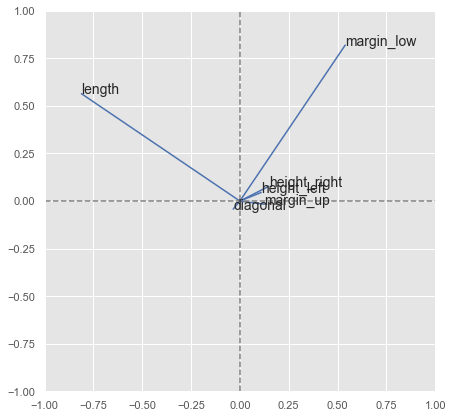

In [72]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='b')
    # Afficher le nom (data.columns[i]) 
    plt.text(x, y, X_scaled_test.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

plt.xlim([-1, 1])
plt.ylim([-1, 1])

**Length est corrélé négativement au premier axe (-0,8) et positivement à margin_low (environ 0,55). Pour le deuxième axe, les poids respectifs s'inversent puisque margin_low représente 0,8 et length -0,55. Les autres variables ne sont corrélées qu'au premier axe, autour de 0,25.**

### Analyse graphique des groupes k_means et de leurs centroïdes sur le plan factoriel :

<Figure size 504x504 with 0 Axes>

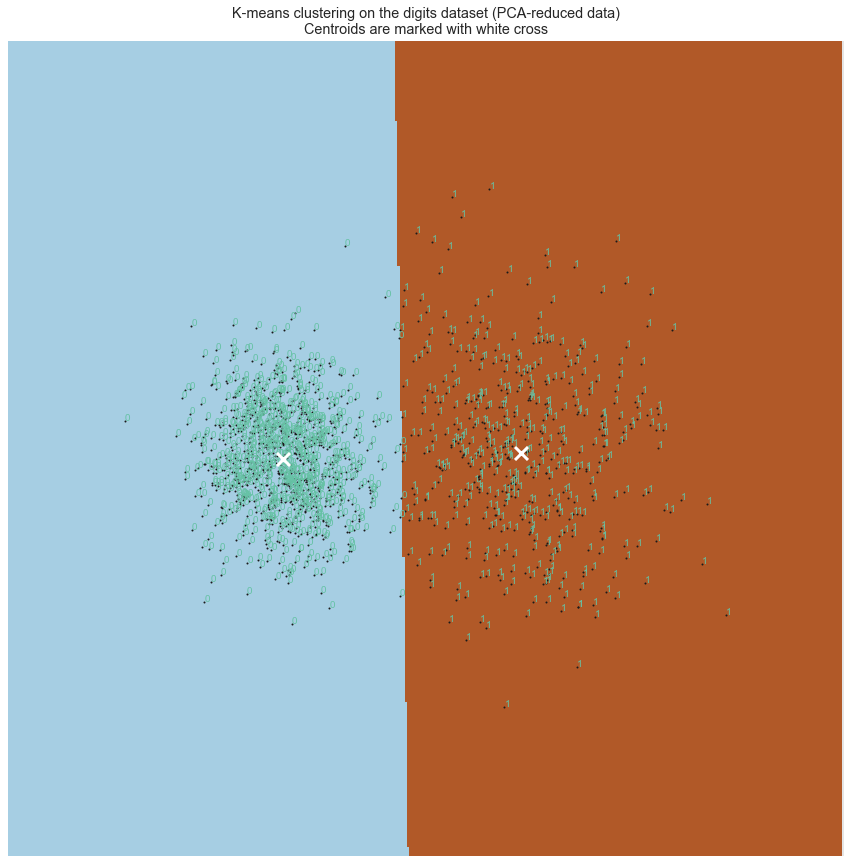

In [73]:
reduced_data = PCA(n_components=2).fit_transform(billets_test)
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
figure = plt.subplots(figsize=(15,15))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

# ajouter le numéro de la classe k-means
for i in range(billets_test.shape[0]): # pour chaque point
    plt.text(reduced_data[i, 0], reduced_data[i, 1], str('%d'% kmeans.labels_[i]),
            color=plt.cm.Set2(kmeans.labels_[i]/10.))
    
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**L'analyse graphique des groupes sur le premier plan factoriel conforte les résultats des tests (Silhouette et Davies-Bouldin). On observe que le groupe 1 des k-means est particulièrement dense : les caractéristiques des vrais billets sont homogènes alors qu'il y a plus de diversité dans les faux billets.**

## Confrontation des groupes kmeans à l'authenticité des billets :

In [74]:
billet_groupe = pd.DataFrame(billets_test.index[idk],kmeans.labels_[idk])
billet_groupe = billet_groupe.reset_index()
billet_groupe = billet_groupe.rename(columns={'level_0': 'groupe_kmeans'}).replace({0:2})

billets_groupe = pd.merge(billet_groupe, billets_corriges, how='left', on= 'index')

billets_groupe

,groupe_kmeans,index,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,2,766,True,172.46,103.89,103.74,3.570000,3.02,112.70
1,2,682,True,172.24,104.51,103.97,4.180000,3.22,113.21
2,2,683,True,172.59,104.22,104.01,4.470000,2.95,113.19
3,2,684,True,172.13,103.76,103.85,3.650000,3.24,112.92
4,2,685,True,172.21,104.28,104.37,4.060000,3.30,113.92
...,...,...,...,...,...,...,...,...,...
1491,1,1167,False,171.84,104.21,104.07,5.850000,3.50,111.16
1492,1,1166,False,171.89,104.23,104.52,4.600000,3.15,110.94
1493,1,1165,False,171.50,104.11,104.14,5.380000,3.53,111.24
1494,1,1180,False,171.68,104.00,104.29,4.900000,3.10,111.77


<AxesSubplot:xlabel='index', ylabel='groupe_kmeans'>

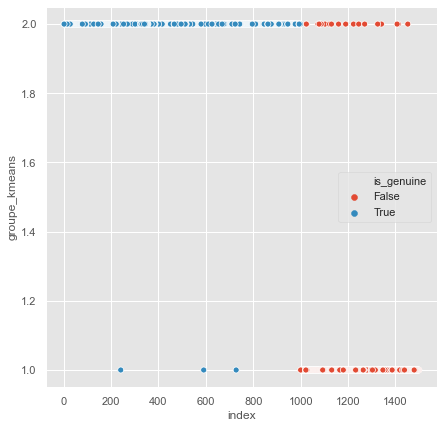

In [75]:
sns.scatterplot(data=billets_groupe, x="index", y="groupe_kmeans", hue="is_genuine")

In [76]:
groupes = pd.pivot_table(billets_groupe, index = 'groupe_kmeans', columns='is_genuine', aggfunc={'is_genuine':np.ma.count})
groupes

is_genuine      
is_genuine         False True 
groupe_kmeans                 
1                    476     3
2                     20   997

**Sur les 1000 vrais billets, 2 ont été identifiés comme faux par la méthode des kmeans (0,2%), et sur les 496 faux billets, 20 ont été identifiés comme vrais (4 %).**

## Influence de chaque variable dans la constitution des groupes kmeans :

In [77]:
#moyenne par variable
m = X_scaled_test.mean()
#TSS
TSS = X_scaled_test.shape[0]*X_scaled_test.var(ddof=0)

#data.frame conditionnellement aux groupes
gb = X_scaled_test.groupby(kmeans.labels_)
#effectifs conditionnels
nk = gb.size()

#moyennes conditionnelles
mk = gb.mean()

#pour chaque groupe écart à la moyenne par variable
EMk = (mk-m)**2
#pondéré par les effectifs du groupe
EM = EMk.multiply(nk,axis=0)
#somme des valeurs => BSS
BSS = np.sum(EM,axis=0)

#carré du rapport de corrélation
#variance expliquée par l'appartenance aux groupes
#pour chaque variable
R2 = BSS/TSS
print(R2)

diagonal        0.017574
height_left     0.140715
height_right    0.223354
margin_low      0.621543
margin_up       0.337159
length          0.739316
dtype: float64


**Les groupes expliquent une grande part de la variance de 'length' (74,2%) et 'margin_low' (61,8%). Cela corrobore l'analyse en composante principale qui montrait l'importance de ces deux variables dans la constitution des deux premiers axes.**

La représentation graphique ci-dessous représente les groupes kmeans et l'authenticité en fonction des ces deux variables :

<AxesSubplot:xlabel='margin_low', ylabel='length'>

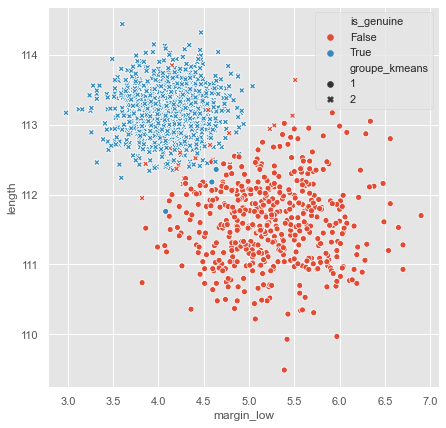

In [78]:
sns.scatterplot(data=billets_groupe, x="margin_low", y="length", hue="is_genuine", style= 'groupe_kmeans')

**On voit que les groupes sont assez homogènes, avec une très forte densité dans le groupe 1. Cependant, certains points du groupe 1, constitué de vrais billets en majorité, sont des faux billets. Ils se situent à la marge entre les groupes 1 et 2 des kmeans. Un faux billet a toutefois des mesures sur les variables length et margin_low conformes au groupe des vrais billets, le groupe 1.**

In [79]:
from sklearn.metrics import confusion_matrix
y_true = billets_groupe.is_genuine 
y_pred = billets_groupe.groupe_kmeans 
confusion_matrix(y_true, y_pred)

array([[  0, 476,  20],
       [  0,   3, 997],
       [  0,   0,   0]], dtype=int64)

**En prenant en compte l'ensemble des variables, le nombre d'erreur d'appréciation de l'authenticité par groupe est le même. Les autres variables ne rendent donc pas le modèle plus précis.**

# Etablissement d'un modèle de prévision avec la regression logistique:

## Préparation des données :

### Importation des échantillons d'apprentissage et test :

In [80]:
DTrain = billets_corriges
print(DTrain.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1496 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1496 non-null   bool   
 1   diagonal      1496 non-null   float64
 2   height_left   1496 non-null   float64
 3   height_right  1496 non-null   float64
 4   margin_low    1496 non-null   float64
 5   margin_up     1496 non-null   float64
 6   length        1496 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.3 KB
None


In [81]:
#y (is_genuine) est la première colonne
yTrain = DTrain.iloc[:,0]
#X (les autres) sont les variables qui précèdent la dernière
XTrain0 = DTrain.iloc[:,1:]
#comptage des modalités de y
print(yTrain.value_counts())

True     1000
False     496
Name: is_genuine, dtype: int64


In [82]:
XTrain0

,diagonal,height_left,height_right,margin_low,margin_up,length
index,,,,,,
0,171.81,104.86,104.95,4.520000,2.89,112.83
1,171.46,103.36,103.66,3.770000,2.99,113.09
2,172.69,104.48,103.50,4.400000,2.94,113.16
3,171.36,103.91,103.94,3.620000,3.01,113.51
4,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...
1303,172.17,104.49,103.76,5.034673,2.93,111.21
1315,172.08,104.15,104.17,4.766075,3.40,112.29
1347,171.72,104.46,104.12,5.714107,3.61,110.31


## Régression logistique avec statsmodels

### Modèlisation et inspection des résultats :

#### Ajouter une constante à la matrice de données :

In [83]:
#importation de l'outil
from statsmodels.tools import add_constant
#données X avec la constante
XTrainBis0 = sm.tools.add_constant(XTrain0)

In [84]:
#vérifier la structure
print(XTrainBis0.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1496 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         1496 non-null   float64
 1   diagonal      1496 non-null   float64
 2   height_left   1496 non-null   float64
 3   height_right  1496 non-null   float64
 4   margin_low    1496 non-null   float64
 5   margin_up     1496 non-null   float64
 6   length        1496 non-null   float64
dtypes: float64(7)
memory usage: 93.5 KB
None


In [85]:
XTrainBis0

,const,diagonal,height_left,height_right,margin_low,margin_up,length
index,,,,,,,
0,1.0,171.81,104.86,104.95,4.520000,2.89,112.83
1,1.0,171.46,103.36,103.66,3.770000,2.99,113.09
2,1.0,172.69,104.48,103.50,4.400000,2.94,113.16
3,1.0,171.36,103.91,103.94,3.620000,3.01,113.51
4,1.0,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,1.0,172.17,104.49,103.76,5.034673,2.93,111.21
1315,1.0,172.08,104.15,104.17,4.766075,3.40,112.29
1347,1.0,171.72,104.46,104.12,5.714107,3.61,110.31


#### Modélisation Logit versus GLM

In [86]:
yTrain

index
0        True
1        True
2        True
3        True
4        True
        ...  
1303    False
1315    False
1347    False
1435    False
1438    False
Name: is_genuine, Length: 1496, dtype: bool

In [87]:
#importation de la classe de calcul
from statsmodels.api import Logit
#régression logistique - on passe la cible et les explicatives
lr0 = Logit(endog=yTrain,exog=XTrainBis0)
#lancer les calculs
#algorithme de Newton-Raphson utilisé par défaut
#https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html
res0 = lr0.fit()

Optimization terminated successfully.
         Current function value: 0.028231
         Iterations 13


In [88]:
#résumé des résultats
print(res0.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1496
Model:                          Logit   Df Residuals:                     1489
Method:                           MLE   Df Model:                            6
Date:                Mon, 07 Feb 2022   Pseudo R-squ.:                  0.9556
Time:                        09:29:23   Log-Likelihood:                -42.234
converged:                       True   LL-Null:                       -950.37
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -205.7224    242.104     -0.850      0.395    -680.238     268.793
diagonal         0.0704      1.092      0.064      0.949      -2.070       2.211
height_left     -1.7080      1.104     -1.54

**Les p-valeur des variables margin_low, margin_up et length sont à 0, ce qui indique leur haut niveau de significativité. Height_right est également significative au seuil de 5%.**

**Comparaison avec le modèle linéaire généralisé (GLM) :**

In [89]:
reg_log1 = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=billets_corriges, family=sm.families.Binomial()).fit()
print(reg_log1.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1496
Model:                                                   GLM   Df Residuals:                     1489
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -42.234
Date:                                       Mon, 07 Feb 2022   Deviance:                       84.468
Time:                                               09:29:23   Pearson chi2:                 2.67e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

#### Analyse des résidus :

In [90]:
n = XTrainBis0.shape[0]
p = 4

In [91]:
n

1496

In [92]:
infl = reg_log1.get_influence(observed=False)

In [93]:
summ_df = infl.summary_frame()
summ_df.sort_values("cooks_d", ascending=False)[:50]

,dfb_Intercept,dfb_diagonal,dfb_height_left,dfb_height_right,dfb_margin_low,dfb_margin_up,dfb_length,cooks_d,standard_resid,hat_diag,dffits_internal
index,,,,,,,,,,,
1122,-0.423993,-0.027634,-0.017788,0.166282,-0.579505,-0.121338,0.990958,0.182323,50.530061,0.000500,1.129718
946,-0.033015,0.208468,0.407181,-0.731760,-0.121295,-0.168687,0.054294,0.109585,-2.368253,0.120316,-0.875842
728,-0.118627,-0.019009,-0.058884,-0.211261,-0.039315,-0.382235,0.682936,0.104426,-5.912256,0.020484,-0.854976
1407,-0.060161,0.003695,-0.192999,0.289033,-0.370182,-0.525177,0.094978,0.078510,5.156194,0.020253,0.741331
1190,0.111644,-0.371033,0.066084,0.123956,-0.054891,0.315112,0.202765,0.060908,1.328018,0.194684,0.652960
591,-0.452881,0.197457,0.186502,0.141032,-0.203887,-0.248733,0.396301,0.059530,-2.916198,0.046712,-0.645531
1160,-0.361508,0.340717,-0.079738,0.321142,-0.023978,0.235950,-0.047325,0.049813,1.499953,0.134187,0.590502
1025,-0.171060,0.111742,0.117603,0.126034,-0.275337,0.147889,-0.072092,0.046134,2.078767,0.069535,0.568275
1412,-0.017170,0.227173,-0.045746,-0.257472,-0.165677,-0.051863,-0.035549,0.044104,4.085950,0.018157,0.555634


**Ces mesures sont basées sur une approximation en une étape des résultats pour la suppression d'une observation. Les approximations en une étape sont généralement exactes pour les petits changements, mais sous-estiment l'ampleur des grands changements. Même si les grands changements sont sous-estimés, ils montrent encore clairement l'effet d'observations influentes.**

**La distance de Cook mesure l'influence. Le seuil pour la distance de Cook est de 0,0027 (4/p-n). 
Les résidus studentisés permettent d'évaluer si une observation est atypique. Une forte valeur de ces résidus au niveau de test α , on considère qu'une observation i est  atypique. Ici au niveau de test de 0,05, la valeur absolue pour i est de 1,97.**

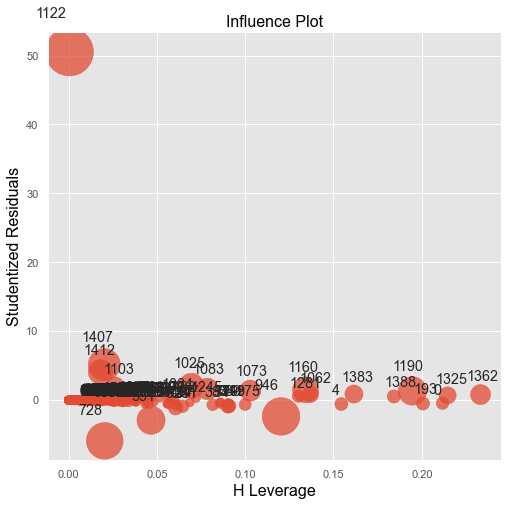

In [94]:
fig = infl.plot_influence()
fig.tight_layout(pad=0.5)

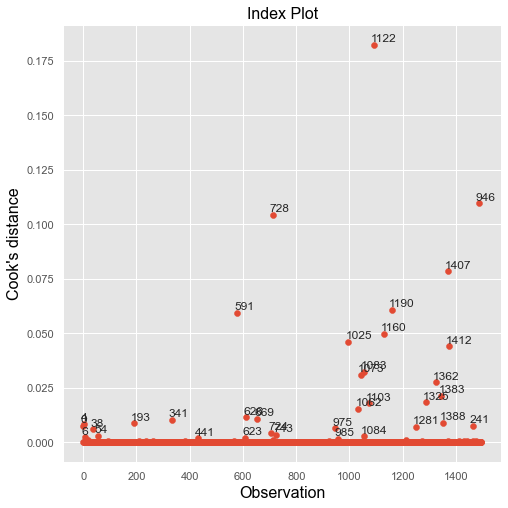

In [95]:
fig = infl.plot_index(y_var="cooks", threshold=2 * infl.cooks_distance[0].mean())
fig.tight_layout(pad=0.5)

**On retire les points atypiques et influents.**

In [96]:
points_influents = summ_df[summ_df.cooks_d > 27/1000]

In [97]:
points_atypiques = summ_df[abs(summ_df.standard_resid) > 1.97]

In [98]:
points_a_retirer_log = pd.concat([points_influents, points_atypiques], axis=1, join="inner")

points_a_retirer_log

,dfb_Intercept,dfb_diagonal,dfb_height_left,dfb_height_right,dfb_margin_low,dfb_margin_up,dfb_length,cooks_d,standard_resid,hat_diag,...,dfb_diagonal,dfb_height_left,dfb_height_right,dfb_margin_low,dfb_margin_up,dfb_length,cooks_d,standard_resid,hat_diag,dffits_internal
index,,,,,,,,,,,,,,,,,,,,,
591,-0.452881,0.197457,0.186502,0.141032,-0.203887,-0.248733,0.396301,0.059530,-2.916198,0.046712,...,0.197457,0.186502,0.141032,-0.203887,-0.248733,0.396301,0.059530,-2.916198,0.046712,-0.645531
728,-0.118627,-0.019009,-0.058884,-0.211261,-0.039315,-0.382235,0.682936,0.104426,-5.912256,0.020484,...,-0.019009,-0.058884,-0.211261,-0.039315,-0.382235,0.682936,0.104426,-5.912256,0.020484,-0.854976
1025,-0.171060,0.111742,0.117603,0.126034,-0.275337,0.147889,-0.072092,0.046134,2.078767,0.069535,...,0.111742,0.117603,0.126034,-0.275337,0.147889,-0.072092,0.046134,2.078767,0.069535,0.568275
1122,-0.423993,-0.027634,-0.017788,0.166282,-0.579505,-0.121338,0.990958,0.182323,50.530061,0.000500,...,-0.027634,-0.017788,0.166282,-0.579505,-0.121338,0.990958,0.182323,50.530061,0.000500,1.129718
1407,-0.060161,0.003695,-0.192999,0.289033,-0.370182,-0.525177,0.094978,0.078510,5.156194,0.020253,...,0.003695,-0.192999,0.289033,-0.370182,-0.525177,0.094978,0.078510,5.156194,0.020253,0.741331
1412,-0.017170,0.227173,-0.045746,-0.257472,-0.165677,-0.051863,-0.035549,0.044104,4.085950,0.018157,...,0.227173,-0.045746,-0.257472,-0.165677,-0.051863,-0.035549,0.044104,4.085950,0.018157,0.555634
946,-0.033015,0.208468,0.407181,-0.731760,-0.121295,-0.168687,0.054294,0.109585,-2.368253,0.120316,...,0.208468,0.407181,-0.731760,-0.121295,-0.168687,0.054294,0.109585,-2.368253,0.120316,-0.875842


**Les 7 billets ci-dessus sont à la fois influents et atypiques et nécessitent donc d'être retirés du modèle d'analyse.**

In [99]:
XTrain00 = XTrain0.drop([591,728,1025,1122,1407,1412,946])
yTrain0 = yTrain.drop([591,728,1025,1122,1407,1412,946])

#### Modèlisation en ne gardant que les variables significatives :

In [100]:
#restriction de XTrain aux valeurs significatives :
XTrain = XTrain00.loc[:, ['height_right', 'margin_low', 'margin_up', 'length']]
#données X avec la constante
XTrainBis = sm.tools.add_constant(XTrain)

In [101]:
XTrainBis

,const,height_right,margin_low,margin_up,length
index,,,,,
0,1.0,104.95,4.520000,2.89,112.83
1,1.0,103.66,3.770000,2.99,113.09
2,1.0,103.50,4.400000,2.94,113.16
3,1.0,103.94,3.620000,3.01,113.51
4,1.0,103.46,4.040000,3.48,112.54
...,...,...,...,...,...
1303,1.0,103.76,5.034673,2.93,111.21
1315,1.0,104.17,4.766075,3.40,112.29
1347,1.0,104.12,5.714107,3.61,110.31


In [102]:
#régression logistique - on passe la cible et les explicatives
lr = Logit(endog=yTrain0,exog=XTrainBis)
#lancer les calculs
#algorithme de Newton-Raphson utilisé par défaut
#https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html
res = lr.fit()

Optimization terminated successfully.
         Current function value: 0.006569
         Iterations 19


In [103]:
#résumé des résultats
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1489
Model:                          Logit   Df Residuals:                     1484
Method:                           MLE   Df Model:                            4
Date:                Mon, 07 Feb 2022   Pseudo R-squ.:                  0.9896
Time:                        09:29:26   Log-Likelihood:                -9.7811
converged:                       True   LL-Null:                       -944.74
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1401.0489    546.472     -2.564      0.010   -2472.114    -329.984
height_right    -7.5473      3.106     -2.430      0.015     -13.635      -1.459
margin_low     -20.7250      7.264     -2.85

**Toutes les variables sont significatives pour le modèle au seuil de 5%.**

## Evaluation globale du modèle en substitution :

### Matrice de confusion :

In [104]:
print(res.params)

const          -1401.048850
height_right      -7.547316
margin_low       -20.724954
margin_up        -39.699361
length            21.388798
dtype: float64


In [105]:
#valeurs estimées par la régression en resubstitution
print(res.fittedvalues)

index
0       11.750526
1       38.621430
2       30.254464
3       47.806233
4        3.318630
          ...    
1303   -26.172570
1315   -19.259086
1347   -89.216326
1435   -53.393267
1438   -38.407084
Length: 1489, dtype: float64


In [106]:
#voici la description du premier individu
print(XTrainBis.iloc[0,:])

const             1.00
height_right    104.95
margin_low        4.52
margin_up         2.89
length          112.83
Name: 0, dtype: float64


In [107]:
#et si on fait le produit scalaire – valeur de regression logistique pour l’individu n°0
import numpy
print(numpy.sum(reg_log1.params*XTrainBis.iloc[0,:]))

-374.563907102028


In [108]:
#matrice de confusion en resubstitution directement fournie par l'outil
print(res.pred_table())

[[489.   3.]
 [  1. 996.]]


**La matrice de confusion permet d'apprécier l'efficacité du modèle.**

**Sur 492 faux billets, 489 ont été reconnus comme faux (99,4%) et 3 faux billets ont été assimilés à des vrais (0,6% de faux vrais billets).**

**Sur 997 vrais billets, la régression logistique permet de reconnaître 99,9% des vrais billets. Seulement 0,1% ont été indument identfiés comme vrais.**

**Au global, le taux de reconnaissance avec la modélisation par regression logistique est de 99,73%.**

**Par rapport à la méthode des k-means, le taux de détection des faux billets est amélioré, passant de 4,4% d'erreur avec les k-means à 0,6%. Le taux de vrais billets classés par erreur en faux billets est amélioré. Le taux de reconnaissance avec les k-means est légèrement inférieur, 98,47%, soit 1,2 % d'écart.**

### Courbe en S :

L'objectif ici est de modéliser la probabilité d'avoir un vrai billet. La visualisation de la fréquence empirique permet de comprendre le choix de courbes en S pour modéliser cette proportion.

In [109]:
beta1 = res.params[0]
beta2 = res.params[1]
beta3 = res.params[2]
beta4 = res.params[3]
beta5 = res.params[4]

La courbe en S s'exprime donc ainsi: 𝑓(𝑥)= (𝑒(𝛽1+𝛽2𝑥+𝛽3𝑥+𝛽4)) / (1+𝑒(𝛽1+𝛽2𝑥+𝛽3𝑥+𝛽4)) 

In [110]:
print(beta1, beta2, beta3, beta4, beta5)

-1401.0488502447936 -7.54731553947052 -20.724954117723808 -39.69936124030466 21.388798094345407


In [111]:
a = XTrain.height_right
b = XTrain.margin_low
c= XTrain.margin_up
d = XTrain.length

fx = np.exp(beta1+beta2*a+beta3*b+beta4*c+beta5*d)/(1+np.exp(beta1+beta2*a+beta3*b+beta4*c+beta5*d))

In [112]:
fx = pd.DataFrame(fx)
fx_genuine = pd.merge (fx, yTrain0, on='index', how='left')
fx_genuine = fx_genuine.rename(columns ={0:'fx'})
fx_genuine

,fx,is_genuine
index,,
0,9.999921e-01,True
1,1.000000e+00,True
2,1.000000e+00,True
3,1.000000e+00,True
4,9.650624e-01,True
...,...,...
1303,4.299296e-12,False
1315,4.323996e-09,False
1347,1.794081e-39,False


In [113]:
fx_genuine.groupby('is_genuine').describe()

fx                                                  \
            count      mean       std           min           25%   
is_genuine                                                          
False       492.0  0.005791  0.058116  3.495597e-42  1.567584e-23   
True        997.0  0.997142  0.031393  4.141693e-01  1.000000e+00   

                                                  
                     50%           75%       max  
is_genuine                                        
False       3.787750e-18  8.292673e-13  0.977084  
True        1.000000e+00  1.000000e+00  1.000000

In [114]:
fx_genuine_true = fx_genuine[fx_genuine.is_genuine == True]

<AxesSubplot:xlabel='fx'>

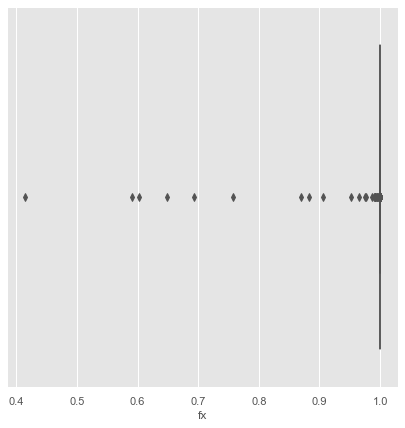

In [115]:
sns.boxplot(fx_genuine_true.fx)

**On constate que la valeur de fx est proche de 1 pour l'essentiel des billets vrais et supérieur à 0,5 pour la majorité d'entre eux.**

In [116]:
fx_genuine_false = fx_genuine[fx_genuine.is_genuine == False]

<AxesSubplot:xlabel='fx'>

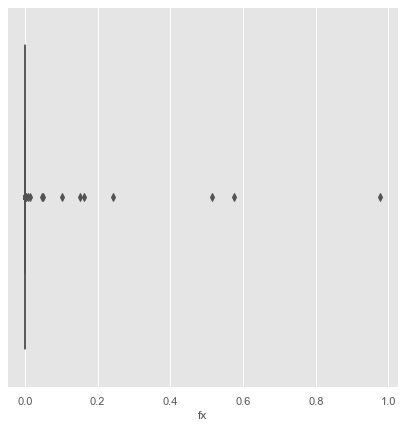

In [117]:
sns.boxplot(fx_genuine_false.fx)

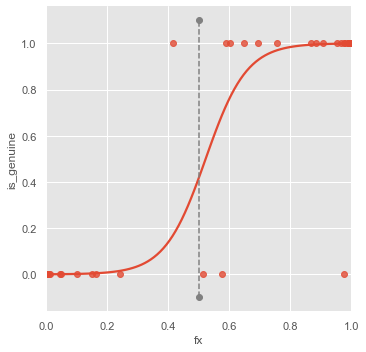

In [118]:
myPlot = sns.lmplot(x="fx", y="is_genuine", data=fx_genuine, y_jitter=.00, logistic=True)
myPlot = myPlot.map_dataframe(plt.plot, [0.5,0.5], [-0.1,1.1], 'b-',color='gray',linestyle='--').add_legend().set_axis_labels("fx", "is_genuine")
plt.show()

**La courbe en S permet de visualiser que plus la valeur de fx augmente, plus la proportion de vrais billets augmente. Avec une valeur de fx à 0,5, tous les vrais billets sauf 1 sont au-delà, et tous les faux billets sauf 3 sont en-deça. Ces observations correspondent aux valeurs de la matrice de confusion.**

### Evaluation basée sur les scores : 

In [119]:
#scores fournis par la régression
scores = Logit(endog=yTrain0,exog=XTrainBis).cdf(res.fittedvalues)
print(scores[:10])

[0.99999211 1.         1.         1.         0.96506242 0.99999998
 0.97569663 1.         0.99999999 1.        ]


#### Le diagramme de fiabilité :

Le diagramme de fiabilité est un outil de diagnostic graphique. Il oppose les scores estimés par le
modèle aux « scores observés ». Ces derniers sont obtenus en calculant la proportion des positifs
observés dans des groupes d’observations. Lesquels groupes sont constitués à partir d’un
découpage en intervalles de largeurs égales des probabilités d’affectation.

In [120]:
#data frame temporaire avec y et les scores
df = pd.DataFrame({"y":yTrain0,"score":scores})
#5 intervalles de largeur égales
intv = pd.cut(df.score,bins=5,include_lowest=True)
#intégrées dans le df
df['intv'] = intv
print(df)

           y         score           intv
index                                    
0       True  9.999921e-01     (0.8, 1.0]
1       True  1.000000e+00     (0.8, 1.0]
2       True  1.000000e+00     (0.8, 1.0]
3       True  1.000000e+00     (0.8, 1.0]
4       True  9.650624e-01     (0.8, 1.0]
...      ...           ...            ...
1303   False  4.299296e-12  (-0.002, 0.2]
1315   False  4.323996e-09  (-0.002, 0.2]
1347   False  1.794081e-39  (-0.002, 0.2]
1435   False  6.480353e-24  (-0.002, 0.2]
1438   False  2.089369e-17  (-0.002, 0.2]

[1489 rows x 3 columns]


A partir de ce dataset, nous pouvons calculer la moyenne des scores estimés dans chaque groupe
délimité par les intervalles.

In [121]:
#moyenne des scores par groupe
m_score = df.pivot_table(index="intv",values="score",aggfunc="mean")
print(m_score)

                  score
intv                   
(-0.002, 0.2]  0.001105
(0.2, 0.4]     0.242118
(0.4, 0.6]     0.523823
(0.6, 0.8]     0.675620
(0.8, 1.0]     0.999416


Puis la proportion des observations (scores observés) positives dans les mêmes groupes. La variable
cible Y étant binaire (0/1), la moyenne fait très bien l’affaire.

In [122]:
#moyenne des y - qui équivaut à une proportion puisque 0/1
m_y = df.pivot_table(index="intv",values="y",aggfunc="mean")
print(m_y)

                      y
intv                   
(-0.002, 0.2]  0.000000
(0.2, 0.4]     0.000000
(0.4, 0.6]     0.500000
(0.6, 0.8]     1.000000
(0.8, 1.0]     0.998992


Le diagramme de fiabilité (reliability diagram) est un graphique nuage de points opposant les scores
estimés et observés. S’ils forment une droite, nous pouvons considérer que la modélisation est
pertinente car le modèle arrive à approcher de manière satisfaisante l’appartenance aux classes des
individus

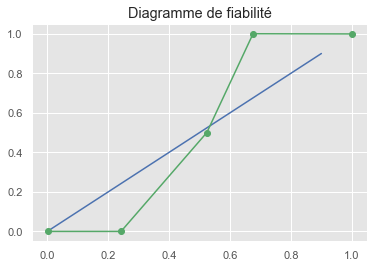

In [123]:
#pouvoir faire apparaître le graphique dans le notebook
%matplotlib inline
#insérer le graphique
import matplotlib.pyplot as plt
#construire la diagonale
plt.plot(numpy.arange(0,1,0.1),numpy.arange(0,1,0.1),'b')
#rajouter notre diagramme
plt.plot(m_score,m_y,"go-")
#titre
plt.title("Diagramme de fiabilité")
#faire apparaître
plt.show()

**Le diagramme de fiabilité indique que le modèle est relativement fiable. Entre 0 et 0.25, les valeurs du modèles sont très similaires aux faux billets de l'échantillon test. Les valeurs au delà de 0,67 sont très similaires aux vrais billets.**

#### Test de Hosmer-Lemeshow :

Le test de Hosmer-Lemeshow procède de la même idée de confrontation entre scores estimés et
observés. Mais il quantifie les écarts à l’aide d’un indicateur statistique.

In [124]:
#data frame temporaire avec y et les scores
df = pd.DataFrame({"y":yTrain0,"score":scores})
#10 intervalles de fréquences égales
intv = pd.qcut(df.score,q=10, duplicates='drop')
#intégrées dans le df
df['intv'] = intv
print(df)

           y         score                                          intv
index                                                                   
0       True  9.999921e-01       (5.4216590550283e-08, 0.99999958486762]
1       True  1.000000e+00                       (0.99999999999998, 1.0]
2       True  1.000000e+00          (0.99999999999838, 0.99999999999998]
3       True  1.000000e+00                       (0.99999999999998, 1.0]
4       True  9.650624e-01       (5.4216590550283e-08, 0.99999958486762]
...      ...           ...                                           ...
1303   False  4.299296e-12  (5.749231279735401e-16, 5.4216590550283e-08]
1315   False  4.323996e-09  (5.749231279735401e-16, 5.4216590550283e-08]
1347   False  1.794081e-39                 (-1e-14, 3.2028211210495e-22]
1435   False  6.480353e-24                 (-1e-14, 3.2028211210495e-22]
1438   False  2.089369e-17  (3.2028211210495e-22, 5.749231279735401e-16]

[1489 rows x 3 columns]


A partir de ce tableau, nous pouvons retracer les étapes du calcul de l’indicateur statistique.

In [125]:
#effectifs par groupe
n_tot = df.pivot_table(index="intv",values="y",aggfunc="count").values[:,0]
print(n_tot)

[149 149 149 149 149 148 149 447]


In [126]:
#somme des scores par groupes
s_scores = df.pivot_table(index='intv',values="score",aggfunc="sum").values[:,0]
print(s_scores)

[3.28952940e-21 5.41702189e-15 2.16491944e-07 1.04000006e+02
 1.48999994e+02 1.48000000e+02 1.49000000e+02 4.47000000e+02]


In [127]:
#nombre de positifs par groupe
n_pos = df.pivot_table(index="intv",values="y",aggfunc="sum").values[:,0]
print(n_pos)

[  0   0   0 104 149 148 149 447]


In [128]:
#nombre de négatifs par groupe
n_neg = n_tot - n_pos
print(n_neg)

[149 149 149  45   0   0   0   0]


In [129]:
C1 = np.sum((n_pos - s_scores)**2/s_scores)
print(C1)

2.164925806167461e-07


In [130]:
C2 = numpy.sum((n_neg - (n_tot - s_scores))**2/((n_tot - s_scores)))
print(C2)

6.34878877046741e-06


In [131]:
#statistique de Hosmer-Lemeshow
HL = C1 + C2
print(HL)

6.565281351084156e-06


Laquelle suite une loi du KHI-2 à 6 degrés de liberté (nombre de groupes - 2).

In [132]:
#librairie scipy
import scipy
#probabilité critique
pvalue = 1.0 - scipy.stats.chi2.cdf(HL,6)
print(pvalue)

1.0


**Nous ne pouvons pas rejeter l’hypothèse d'incompatibilité de notre modèle avec les données, la p-value étant inférieur à la valeur du Chi2 au seuil de 5%.** 

## Tests de significativité des coefficients :

Il s’agit de tester la nullité de tout ou partie des
coefficients de la régression. Nous nous appuyons sur les 2 approches qui font référence : le test du
rapport de vraisemblance et le test de Wald.

### Le test du rapport de vraissemblance :

Il s’agit de vérifier si les coefficients, à l’exception de la constante, sont tous simultanément nuls.

Le test du rapport de vraissemblance est fondé sur la confrontation des déviances du modèle et du null modèle (modèle trivial
composé exclusivement de la constante). On se rappelle que la déviance est égale à (-2) x logvraisemblance.

In [154]:
#déviance du modèle
dev_modele = (-2) * res.llf
print("Deviance du modèle : %.4f " % (dev_modele))
#déviance du modèle trivial
dev_null = (-2) * res.llnull
print("Deviance du modèle trivial: %.4f " % (dev_null))
#statistique du rapport de vraisemblance
LR_stat = dev_null - dev_modele
print("Stat. du rapport de vraisemblance : %.4f " % (LR_stat))
#laquelle était fournie directement par l'objet
print("Stat. du rapport de vraisemblance via l'objet résultat : %.4f" % (res.llr))

Deviance du modèle : 19.5623 
Deviance du modèle trivial: 1889.4751 
Stat. du rapport de vraisemblance : 1869.9128 
Stat. du rapport de vraisemblance via l'objet résultat : 1869.9128


In [134]:
#degré de liberté du test (nb. de coef. estimés excepté la constante)
print(res.df_model)

4.0


In [135]:
#librairie scipy
import scipy
#p-value du test
pvalue = 1.0 - scipy.stats.chi2.cdf(res.llr,res.df_model)
print(pvalue)

0.0


### Test de Wald

Il est également possible de s’appuyer sur la normalité asymptotique des estimateurs du maximum de vraisemblance, et d’appliquer le principe du test de Wald, pour tester la nullité simultanée de plusieurs coefficients.

In [136]:
#afficher la matrice de var-covar des coefs. estimés.
print(res.cov_params())
#récupération sous une forme matricielle
vcov = res.cov_params().values

                      const  height_right   margin_low    margin_up  \
const         298631.249503   1000.172114  3585.614443  7371.492730   
height_right    1000.172114      9.648319    18.006285    37.743620   
margin_low      3585.614444     18.006285    52.760417   105.115808   
margin_up       7371.492731     37.743620   105.115808   226.551175   
length         -3931.644597    -19.601557   -53.613830  -111.061485   

                   length  
const        -3931.644597  
height_right   -19.601557  
margin_low     -53.613830  
margin_up     -111.061485  
length          58.365010  


In [137]:
#nous avons bien le carré des ecarts-type estimés sur la diagonale
#à confronter avec les sorties de summary
print(numpy.sqrt(numpy.diagonal(vcov)))

[546.4716365    3.10617441   7.26363664  15.05161701   7.63969961]


Récupération de la sous-partie de la matrice de variance covariance :

In [138]:
#indice des coefficients concernés
indices = [1,2,3,4]
#sous-matrice de var.covar
subset_vcov = numpy.zeros(shape=(4,4))
for i in range(4):
    for j in range(4):
        subset_vcov[i,j] = vcov[indices[i],indices[j]]
#vérification
print(subset_vcov)

[[   9.64831946   18.00628509   37.7436204   -19.60155726]
 [  18.00628509   52.76041721  105.11580816  -53.61382952]
 [  37.7436204   105.11580816  226.55117469 -111.06148465]
 [ -19.60155726  -53.61382952 -111.06148465   58.36501015]]


In [139]:
#inversion de cette matrice
inv_subset_vcov = numpy.linalg.inv(subset_vcov)
print(inv_subset_vcov)

[[ 0.32792633  0.01024215 -0.01165867  0.09735555]
 [ 0.01024215  0.34738375 -0.07096976  0.18749811]
 [-0.01165867 -0.07096976  0.08050404  0.08408137]
 [ 0.09735555  0.18749811  0.08408137  0.38206134]]


In [140]:
#coefficients estimés
a = res.params[indices].values

Reste à calculer la forme quadratique correspondant à la statistique de test et la probabilité critique associée :

In [141]:
#produit matriciel
stat_3 = numpy.dot(a,numpy.dot(inv_subset_vcov,a))
print("Stat. de test : %.4f" % (stat_3))
#p-value (ddl = 3 puisque 3 coef. à tester)
pvalue = 1.0 - scipy.stats.chi2.cdf(stat_3,3)
print("p-value : %.4f" % (pvalue))

Stat. de test : 8.5351
p-value : 0.0362


**La nullité simultanée des coefficients n’est pas démentie par les données au risque 5%.**

### Confronter les critères AIC (Akaike) ou BIC (Schwartz) du modèle étudié avec ceux du modèle trivial (null modèle) :

In [142]:
#AIC du modèle
print("AIC du modèle : %.4f" % (res.aic))
#AIC du modèle trivial - 1 seul param. estimé, la constante
aic_null = (-2) * res.llnull + 2 * (1)
print("AIC du modèle trivial : %.4f" % (aic_null))

AIC du modèle : 29.5623
AIC du modèle trivial : 1891.4751


**Comme (AIC_modèle < AIC_null), nous pouvons conclure que notre modèle est globalement pertinent.**

In [143]:
#BIC du modèle
print("BIC du modèle : %.4f" % (res.bic))
#BIC du modèle trivial - 1 seul param. estimé, la constante
bic_null = (-2) * res.llnull + numpy.log(n) * (1)
print("BIC du modèle trivial : %.4f" % (bic_null))

BIC du modèle : 56.0916
BIC du modèle trivial : 1896.7856


**Comme (BIC_modèle < BIC_null), nous pouvons conclure que notre modèle est globalement pertinent.**

# Prédiction :

**A l'issue de cette démarche, nous avons construit et évalué deux modèles, celui obtenu par la méthode de la régression logistique étant plus performant que celui obtenu par la méthode des K_means. Il s'agit maintenant de prédire l'authenticité d'un jeu de billets à partir de leurs seules dimensions :**

In [155]:
# loading the testing dataset 
dftest0 = pd.read_csv('billets_test_soutenance.csv', index_col = 6)

dftest0

,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,
B_1,172.09,103.95,103.73,4.39,3.09,113.19
B_2,171.52,104.17,104.03,5.27,3.16,111.82
B_3,171.78,103.80,103.75,3.81,3.24,113.39
B_4,172.02,104.08,103.99,5.57,3.30,111.10
B_5,171.79,104.34,104.37,5.00,3.07,111.87


## En utilisant le modèle de régression logistique :

In [156]:
XTest = dftest0.loc[:, ['height_right', 'margin_low', 'margin_up', 'length']] 

In [157]:
#préparation de l'échantillon test
#par adjonction de la constante
XTest_Bis = add_constant(XTest)
print(XTest_Bis.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, B_1 to B_5
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         5 non-null      float64
 1   height_right  5 non-null      float64
 2   margin_low    5 non-null      float64
 3   margin_up     5 non-null      float64
 4   length        5 non-null      float64
dtypes: float64(5)
memory usage: 412.0+ bytes
None


In [158]:
#calcul de la prédiction sur l'échantillon test
predProbaSm = res.predict(XTest_Bis)
#à l'évidence nous avons les probabilités d'affectation
print(predProbaSm.describe())

count    5.000000e+00
mean     4.000000e-01
std      5.477226e-01
min      4.572298e-25
25%      2.143486e-13
50%      4.603013e-10
75%      1.000000e+00
max      1.000000e+00
dtype: float64


In [159]:
#convertir en prédiction brute, avec 67% de vrais billets dans le modèle
predSm = np.where(predProbaSm > 0.67, 1, 0)
print(np.unique(predSm,return_counts=True))

(array([0, 1]), array([3, 2], dtype=int64))


In [160]:
predSm

array([1, 0, 1, 0, 0])

**On peut dire que les billets A_1, A_2 et A_3 sont faux et que les billets A_4 et A_5 sont vrais.**

## En utilisant les centroïdes issus des k-means :

In [161]:
#Centrage et Réduction de l'échantillon test
std_scale_test0 = sklearn.preprocessing.StandardScaler().fit(dftest0)
X_scaled_test0 = std_scale_test0.transform(dftest0)

In [162]:
#préparation de l'échantillon test
#par adjonction de la constante
XTest_Bis0 = add_constant(dftest0)
print(XTest_Bis0.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, B_1 to B_5
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         5 non-null      float64
 1   diagonal      5 non-null      float64
 2   height_left   5 non-null      float64
 3   height_right  5 non-null      float64
 4   margin_low    5 non-null      float64
 5   margin_up     5 non-null      float64
 6   length        5 non-null      float64
dtypes: float64(7)
memory usage: 492.0+ bytes
None


In [163]:
kmeans.fit(X_scaled_test0)

KMeans(n_clusters=2)

In [164]:
kmeans.predict(X_scaled_test0)

array([1, 0, 1, 0, 0])

**En utilisant la méthode des k_means, on obtient le même résultat. Les trois premiers billets sont assignés au groupe 0, qui a été identifié comme le groupe des faux billets. Les deux derniers sont assignés au groupe 1, le groupe des vrais billets.**